<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Figure 3: Future projections for each impact

_Authors: Oriana Chegwidden and Jeremy Freeman_

The methods below conduct the analyses to recreate Figure 4 included the
manuscript <<< insert doi >>>. Future risks for fire. We show median changes in
risk with respect to the historic.


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy as sp
from carbonplan_forest_risks import load, setup, plot, fit, utils, prepare, collect
import xarray as xr
from carbonplan_forest_risks.utils import get_store


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from showit import image
import scipy as sp
import geopandas as gpd
import regionmask as rm
import altair as alt
alt.themes.enable("carbonplan_light")

ThemeRegistry.enable('carbonplan_light')

In [3]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
coarsen = 4

In [5]:
mask = (
    (
        load.nlcd(store="az", year=2001).sel(band=[41, 42, 43, 90]).sum("band")
        > 0.25
    )
    .astype("float")
    .coarsen(x=coarsen, y=coarsen, boundary="trim")
    .mean()
)

In [6]:
historical_fire = xr.open_zarr(
    get_store("carbonplan-scratch", "data/fire_historical_v3.zarr")
)
fire_mask = ~np.isnan(historical_fire.historical.isel(time=0).drop("time"))

In [8]:
ds = (
    xr.open_zarr(get_store("carbonplan-scratch", "data/fire_future_v3.zarr"))
    .assign_coords({"x": mask.x, "y": mask.y})
    .where(fire_mask)
    .groupby("time.year")
    .sum()
    .where(fire_mask)
    .compute()
)

In [9]:
ds_remaining = (
    xr.open_zarr(
        get_store("carbonplan-scratch", "data/fire_future_v3_remaining.zarr")
    )
    .assign_coords({"x": mask.x, "y": mask.y})
    .groupby("time.year")
    .sum()
    .where(fire_mask)
    .compute()
)

In [10]:
ds = xr.merge([ds, ds_remaining])

In [11]:
historical_annual = (
    xr.open_zarr(
        get_store("carbonplan-scratch", "data/fire_historical_v3.zarr")
    )
    .assign_coords({"x": mask.x, "y": mask.y})
    .groupby("time.year")
    .sum()
    .where(fire_mask)
    .mean(dim=["x", "y"])
    .compute()
)

## Plot the figure


In [18]:
gcms = [
    ("MRI-ESM2-0", (0, 0)),
    ("MIROC-ES2L", (1, 0)),
    ("MPI-ESM1-2-LR", (2, 0)),
    ("ACCESS-ESM1-5", (3, 0)),
    ("ACCESS-CM2", (4, 0)),
    ("CanESM5-CanOE", (5, 0)),
]
scenario_colors = {
    "ssp245": "#59A82F",
    "ssp370": "#D8B525",
    "ssp585": "#D83232",
}
scenario_colors_light = {
    "ssp245": "#DEEED5",
    "ssp370": "#F7F0D3",
    "ssp585": "#F7D6D6",
}
titles = [
    "Burn area\n[fraction/year]",
    "Drought mortality\n[]",
    "Biotic agent mortality\n[]",
]

In [19]:
future_ts = ds.mean(dim=["x", "y"]).rolling(dim={"year": 10}).mean().compute()

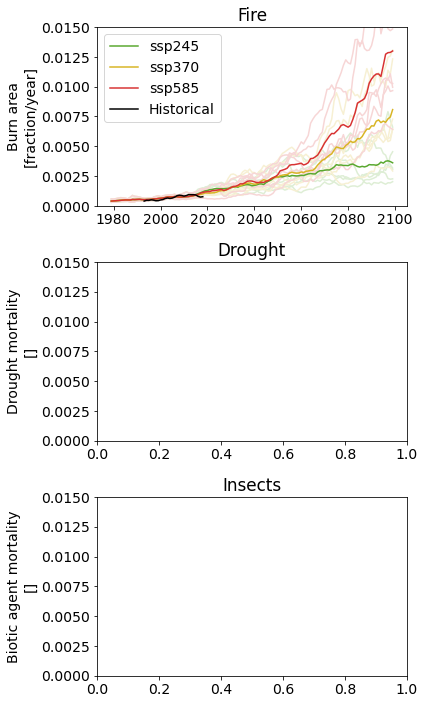

In [23]:
plt.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

fig, axarr = plt.subplots(nrows=3, figsize=(6, 10), sharey=True)

for scenario in ["ssp245", "ssp370", "ssp585"]:
    for (gcm, location) in gcms:
        future_ts["{}_{}".format(gcm, scenario)].sel(
            year=slice("1970", "2099")
        ).plot(ax=axarr[0], color=scenario_colors_light[scenario], alpha=1)

for scenario in ["ssp245", "ssp370", "ssp585"]:
    future_ts[["{}_{}".format(gcm[0], scenario) for gcm in gcms]].to_array(
        dim="vars"
    ).mean("vars").plot(
        ax=axarr[0], color=scenario_colors[scenario], label=scenario
    )
historical_annual["historical"].rolling(dim={"year": 10}).mean().plot(
    ax=axarr[0], color="k", linestyle="-", label="Historical"
)
axarr[0].set_xlabel("")
axarr[0].set_ylim(0, 0.015)
axarr[0].set_ylim(0, 0.015)

axarr[0].legend()

for i, impact in enumerate(titles):
    axarr[i].set_ylabel(impact)
impacts = ["Fire", "Drought", "Insects"]
for i, impact in enumerate(impacts):
    axarr[i].set_title(impact)
plt.tight_layout()
plt.savefig("future_traces.svg", format="svg")